In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from time import time

In [2]:
import networkx as nx
import graph_tool.all as gt

In [3]:
from numba import set_num_threads, get_num_threads

In [90]:
@jit(nopython=True, parallel=False)
def own_parallel_triangle_comp(A):
    triangles = np.zeros(shape=(A.shape[0], A.shape[1]), dtype=np.int16)
    A = np.asarray(A, dtype=np.int16)
    for i in range(A.shape[0]):
        for j in prange(A.shape[1]):
            triangles[i,j] += np.sum(A[i,:] * A[:,j]) * A[i,j]
    return np.sum(triangles, axis=1)/2

In [5]:
@jit(nopython=True)
def parallel_global_clustering_coef(A):
    t = own_parallel_triangle_comp(A)
    d = node_degree_parallel(A)
    clustering = np.zeros(shape=t.shape[0])
    mask = t !=0
    clustering = t[mask] / ((d[mask] * (d[mask] - 1)))
    
    sum_k = np.sum(d*(d-1))
    
    #print (2*clustering)
    return 2*np.sum(clustering)/mask.shape[0]#np.sum(mask) # np.sum((3*triangles/(0.5*sum_k)))

In [6]:
@jit(nopython=True, parallel=True)
def avg_node_degree_parallel(A):
    # it assumes matrix A is correct (no validation)
    degree = np.zeros(shape=len(A))
    for i in prange(len(A)):
        degree[i] = np.sum(A[i])
    return np.mean(degree)

In [7]:
@jit(nopython=True, parallel=True, cache=True)
def node_degree_parallel(A):
    # it assumes matrix A is correct (no validation)
    degree = np.zeros(shape=len(A))
    for i in prange(len(A)):
        degree[i] = np.sum(A[i])
    return degree

In [59]:
@jit(nopython=True, cache=True)
def node_degree_njit(A):
    # it assumes matrix A is correct (no validation)
    degree = np.zeros(shape=len(A))
    for i in range(len(A)):
        degree[i] = np.sum(A[i])
    return degree

In [9]:
def avg_node_degree_py(A):
    # it assumes matrix A is correct (no validation)
    degree = [ 0 for i in range(len(A)) ]
    for i in range(len(A)):
        degree[i] = sum(A[i])
    return sum(degree)/float(len(degree))

@jit(nopython=True)
def avg_node_degree_njit(A):
    # it assumes matrix A is correct (no validation)
    degree = np.zeros(shape=len(A))
    for i in range(len(A)):
        degree[i] = np.sum(A[i])
    return np.mean(degree)

@jit(nopython=True, parallel=True)
def avg_node_degree_parallel(A):
    # it assumes matrix A is correct (no validation)
    degree = np.zeros(shape=len(A))
    for i in prange(len(A)):
        degree[i] = np.sum(A[i])
    return np.mean(degree)

In [10]:
@jit(nopython=True)
def get_index_pairs(N):
    E = np.zeros(shape=((N*(N-1))//2, 2), dtype=np.int32)
    c = 0
    for i in range(N):
        for j in range(i+1, N):
            E[c,0] = i
            E[c,1] = j
            c += 1
    return E

In [11]:
@jit(nopython=True)
def get_num_triangles_njit(A):
    N = A.shape[0]
    num_triangles = 0
    for i in range(N):
        for j in range(i+1, N):
            print (A[i,j], A[j,i])
            if (A[i,j] > 0 and A[i,j] == A[j,i]): # are n_i and n_j connected?
                #print ("i=%i j=%i sum=%i" % (i,j,np.sum(A[i,:] & A[j,:])))
                num_triangles += np.sum(A[i,:] & A[j,:])
    return num_triangles//3

In [12]:
@jit(nopython=True, parallel=True)
def get_num_triangles_parallel(A, e_pairs):
    N = A.shape[0]
    num_triangles = 0
    inter = np.zeros(shape=len(e_pairs), dtype=np.int32)
    
    for i_pair in prange(len(e_pairs)):
        i = e_pairs[i_pair, 0]
        j = e_pairs[i_pair, 1]
        if ((A[i,j]) and (A[i,j] == A[j,i])):
            inter[i_pair] = np.sum(A[i,:] & A[j,:])
            
    return np.sum(inter)//3

In [13]:
@jit(nopython=True)
def get_triangles_per_node(A):
    N = A.shape[0]
    #triangles_per_node = np.zeros(shape=N, dtype=np.int32)
    #num_triangles = 0
    
    triangles = np.zeros(shape=N, dtype=np.int16)
    for i in range(N):
        for j in range(A.shape[1]):
            triangles[i] += np.sum(A[i,:] * A[:,j]) * A[i,j]
    return triangles/2
    
    #for i in range(N):
    #    triangles_per_node
    #    for j in range(N):
    #        if i!=j:
    #            triangles_per_node[i] += np.sum(A[i,:] & A[j,:])
    
    # for i_pair in prange(len(e_pairs)):
    #     i = e_pairs[i_pair, 0]
    #     j = e_pairs[i_pair, 1]
    #     if ((A[i,j]) and (A[i,j] == A[j,i])):
    #         inter[i_pair] = np.sum(A[i,:] & A[j,:])
            
    #return triangles_per_node

In [14]:
def avg_node_degree(A, rep=10):
    l_comptime_py       = np.zeros(shape=rep)
    l_comptime_njit     = np.zeros(shape=rep)
    l_comptime_parallel = np.zeros(shape=rep)
    for i in range(rep):
        t = time()
        mat_avg_node_degree_py = avg_node_degree_py(A)
        t = time() - t
        l_comptime_py[i] = t
        
        t = time()
        mat_avg_node_degree_njit = avg_node_degree_njit(A)
        t = time() - t
        l_comptime_njit[i] = t
        
        t = time()
        mat_avg_node_degree_parallel = avg_node_degree_parallel(A)
        t = time() - t
        l_comptime_parallel[i] = t
    
    results = {
        "comptimes" : [
            l_comptime_py, l_comptime_njit, l_comptime_parallel
        ],
        "out" : [
            mat_avg_node_degree_py, mat_avg_node_degree_njit, mat_avg_node_degree_parallel
        ]
        
    }
    return results

In [15]:
def from_edges_get_adj_matrix(edges):
    N = np.max(edges)+1
    A = np.zeros(shape=(N,N), dtype=np.bool)
    
    for i_e in range(len(edges)):
        i = edges[i_e][0]
        j = edges[i_e][1]
        A[i,j] += 1
        A[j,i] = A[i,j]
    return A
        

In [16]:
@jit(nopython=True, parallel=True)
def get_triangles_parallel(A, e_pairs):
    N = A.shape[0]
    inter = np.ones(shape=len(e_pairs), dtype=np.int32)
    
    for i_pair in prange(len(e_pairs)):
        i = e_pairs[i_pair, 0]
        j = e_pairs[i_pair, 1]
        if ((A[i,j]) and (A[i,j] == A[j,i])):
            inter[i_pair] = np.sum(A[i,:] & A[j,:])
            
    return inter//3

In [17]:
def global_clustering_coef(A):
    t = get_triangles_per_node(A)
    d = node_degree_njit(A)
    clustering = np.zeros(shape=t.shape[0])
    mask = t !=0
    clustering = t[mask] / ((d[mask] * (d[mask] - 1)))
    
    #e_pairs = get_index_pairs(A.shape[0])
    #triangles = get_triangles_parallel(A, e_pairs) 
    ##print ("triangles", t)
    ##print ("degree   ", d)
    #k = k[k>1]
    #k[k<2] = 0
    sum_k = np.sum(d*(d-1))
    ###print ("?        ", np.sum(t/(2*d*(d-1))))
    ##print ("k        ", np.sum(t/sum_k))
    ##print ("test", np.sum(2*d/sum_k))
    ##print ("sum", sum_k)
    #print (2*clustering)
    return 2*np.sum(clustering)/mask.shape[0]#np.sum(mask) # np.sum((3*triangles/(0.5*sum_k)))

$\bar{C} = \frac{1}{N} \frac{3 \lambda_G}{\frac{1}{2} k_i(k_i-1)} = \frac{6 \lambda_G}{N k_i(k_i-1)}$

In [18]:
def own_triangle_comp(A):
    triangles = np.zeros(shape=A.shape[0], dtype=np.int16)
    A = np.asarray(A, dtype=np.int16)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            triangles[i] += np.sum(A[i,:] * A[:,j]) * A[i,j]
    return triangles/2

In [19]:
def plot_avg_node_degree():
    l_mean = [ np.mean(res_avg_node_degree['comptimes'][i]/res_avg_node_degree['comptimes'][-1]) for i in range(2)]
    l_std = [ np.std(res_avg_node_degree['comptimes'][i]/res_avg_node_degree['comptimes'][-1]) for i in range(2)]
    #plt.plot(list(range(3)), l_mean)
    #plt.plot(list(range(3)), l_std)
    plt.errorbar(list(range(2)), l_mean, yerr=l_std ) #uplims=True, label='uplims=True
    

-----

## Example: Karate Club

In [20]:
edges = np.array([[2,1],[3,1],[3,2],[4,1],[4,2],[4,3],[5,1],[6,1],[7,1],[7,5],[7,6],[8,1],[8,2],[8,3],[8,4],[9,1],[9,3],[10,3],[11,1],[11,5],[11,6],[12,1],[13,1],[13,4],[14,1],[14,2],[14,3],[14,4],[17,6],[17,7],[18,1],[18,2],[20,1],[20,2],[22,1],[22,2],[26,24],[26,25],[28,3],[28,24],[28,25],[29,3],[30,24],[30,27],[31,2],[31,9],[32,1],[32,25],[32,26],[32,29],[33,3],[33,9],[33,15],[33,16],[33,19],[33,21],[33,23],[33,24],[33,30],[33,31],[33,32],[34,9],[34,10],[34,14],[34,15],[34,16],[34,19],[34,20],[34,21],[34,23],[34,24],[34,27],[34,28],[34,29],[34,30],[34,31],[34,32],[34,33]])
edges -= 1

In [21]:
A_karate = from_edges_get_adj_matrix(edges)
A_karate.shape

/tmp/ipykernel_19988/2687033960.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = np.zeros(shape=(N,N), dtype=np.bool)


(34, 34)

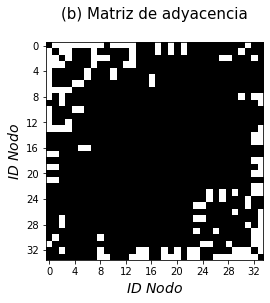

In [22]:
#plt.figure(figsize=(4,4), facecolor='w'); 
f, ax = plt.subplots(figsize=(4,4), facecolor='w')
im = ax.imshow(A_karate, cmap='Greys_r'); 
ax.set_xlabel("$ID\ Nodo$", fontsize=14)
ax.set_ylabel("$ID\ Nodo$", fontsize=14)
ax.set_xticks(np.arange(0, A_karate.shape[0], 4))
ax.set_yticks(np.arange(0, A_karate.shape[0], 4))
ax.set_title("(b) Matriz de adyacencia\n", fontsize=15)
plt.savefig("figs/adj_karate.pdf")

**Calculos**

In [23]:
rep = 100 # num repetitions

In [24]:
def get_times(A, f_degree, f_tri, f_clust, rep=10):
    # OWN 

    times_own_degree = np.zeros(shape=rep)
    times_own_triang = np.zeros(shape=rep)
    times_own_clust  = np.zeros(shape=rep)
    res_own_degree = None
    res_own_triang = None
    res_own_clust  = None
    for i in range(rep):
        # degree
        t = time()
        res_own_degree = f_degree(A)
        t = time()-t
        times_own_degree[i] = t

        # triangles
        A = np.asarray(A, dtype=np.int16)
        t = time()
        res_own_triang = f_tri(A)
        t = time()-t
        times_own_triang[i] = t

        # clustering
        t = time()
        res_own_clust = f_clust(A)
        t = time()-t
        times_own_clust[i] = t
    
    summary = {
        "times" : { "d" : times_own_degree, "t" : times_own_triang, "c" : times_own_clust },
        "results" : { "d" : res_own_degree, "t" : res_own_triang, "c" : res_own_clust}
    }
    return summary

In [91]:
@jit(nopython=True)
def mult_mat(A, B):
    R = np.zeros(shape=(A.shape[0], A.shape[1]))
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            for k in range(A.shape[0]):
                R[i,j] += A[i, k]*B[k,j]
    return R

In [170]:
### NX ###
def nx_average_degrees(G):
    degree = 0
    for x in range(len(G)):
        degree = degree + G.degree(x)
    summary = degree / len(G)
    return int(summary)

def nx_degrees(G):
    degree = np.zeros(shape=len(G))
    for i in range(len(G)):
        degree[i] = G.degree(i)
    #summary = degree / len(G)
    return degree

def nx_triangles_graph(G):
    c = 0
    add = 0
    summary = 0
    for c in range(len(G)):
        add = add + nx.triangles(G,c)
        #print(nx.triangles(G,c))
    summary = add / 3
    return int(summary)

def nx_clustering_media(G):
    clustering = 0
    for x in range(len(G)):
        clustering = clustering + nx.clustering(G,x)
    summary = clustering / len(G)
    return summary

### GT ###
def gt_average_degrees(g):
    degree = 0
    list_degrees = g.get_total_degrees(g.get_vertices())
    for x in range(len(list_degrees)):
        degree = degree + list_degrees[x]
    summary = degree / len(list_degrees)
    return int(summary)   

def gt_triangles_graph(g):
    A = gt.adjacency(g).toarray()
    A_mult = mult_mat(mult_mat(A, A), A) #A@A@A
    #den = g.get_total_degrees(g.get_vertices())
    #den = den*(den-1)
    triang = np.diagonal(A_mult)/2 #/ den
    return triang

def gt_clustering_media(g, n):
    A = gt.adjacency(g).toarray()
    A_mult = A@A@A
    den = g.get_total_degrees(g.get_vertices())
    den = den*(den-1)
    summary = (np.diagonal(A_mult))/(den)
    #clustering = 0
    #c = gt.local_clustering(g)
    #for x in range(n):
    #    clustering = clustering + c[x]
    #summary = clustering / n
    return summary

def nx_create_graph(A):
    G = nx.from_numpy_matrix(A)
    return G

def gt_create_graph(A):
    G = gt.Graph()
    G.add_edge_list(np.transpose(A.nonzero()))
    return G

In [166]:
def get_times_nx(A, rep=10):
    times_own_degree = np.zeros(shape=rep)
    times_own_triang = np.zeros(shape=rep)
    times_own_clust  = np.zeros(shape=rep)
    res_own_degree = None
    res_own_triang = None
    res_own_clust  = None
    
    G = nx_create_graph(A)

    for i in range(rep):
        # degree
        t = time()
        res_own_degree = nx_degrees(G)
        t = time()-t
        times_own_degree[i] = t

        # triangles
        t = time()
        res_own_triang = nx_triangles_graph(G)
        t = time()-t
        times_own_triang[i] = t

        # clustering
        t = time()
        res_own_clust = nx_clustering_media(G)
        t = time()-t
        times_own_clust[i] = t
    
    summary = {
        "times" : { "d" : times_own_degree, "t" : times_own_triang, "c" : times_own_clust },
        "results" : { "d" : res_own_degree, "t" : res_own_triang, "c" : res_own_clust}
    }
    return summary

In [184]:
def get_times_gt(A, rep=10):
    times_own_degree = np.zeros(shape=rep)
    times_own_triang = np.zeros(shape=rep)
    times_own_clust  = np.zeros(shape=rep)
    res_own_degree = None
    res_own_triang = None
    res_own_clust  = None
        
    g = gt_create_graph(A)

    for i in range(rep):
        # degree
        t = time()
        res_own_degree = gt_average_degrees(g)
        #den = g.get_total_degrees(g.get_vertices())
        #den = den*(den-1)
        #summary = (np.diagonal(A_mult))/(den)
        t = time()-t
        times_own_degree[i] = t

        # triangles
        t = time()
        res_own_triang = gt_triangles_graph(g)
        #A = gt.adjacency(g).toarray()
        #A_mult = A@A@A
        t = time()-t
        times_own_triang[i] = t

        # clustering
        n = gt.adjacency(g).toarray().shape[0]
        t = time()
        res_own_clust = gt_clustering_media(g, n)
        t = time()-t
        times_own_clust[i] = t
    
    summary = {
        "times" : { "d" : times_own_degree, "t" : times_own_triang, "c" : times_own_clust },
        "results" : { "d" : res_own_degree, "t" : res_own_triang, "c" : res_own_clust}
    }
    return summary

In [95]:
summary_own = get_times(
    A=A_karate, 
    f_degree=node_degree_njit, 
    f_tri=get_triangles_per_node, 
    f_clust=node_degree_njit, rep=rep)

In [175]:
summary_own

{'times': {'d': array([1.57356262e-05, 1.66893005e-06, 7.15255737e-07, 9.53674316e-07,
         9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 1.19209290e-06,
         9.53674316e-07, 9.53674316e-07, 7.15255737e-07, 7.15255737e-07,
         9.53674316e-07, 9.53674316e-07, 9.53674316e-07]),
  't': array([8.13007355e-05, 7.41481781e-05, 9.39369202e-05, 7.53402710e-05,
         7.34329224e-05, 7.29560852e-05, 7.39097595e-05, 7.36713409e-05,
         7.39097595e-05, 7.34329224e-05, 7.29560852e-05, 7.31945038e-05,
         7.31945038e-05, 7.34329224e-05, 7.34329224e-05]),
  'c': array([3.33786011e-06, 9.53674316e-07, 1.66893005e-06, 9.53674316e-07,
         1.19209290e-06, 9.53674316e-07, 9.53674316e-07, 7.15255737e-07,
         9.53674316e-07, 7.15255737e-07, 7.15255737e-07, 7.15255737e-07,
         1.19209290e-06, 7.15255737e-07, 9.53674316e-07])},
 'results': {'d': array([16.,  9., 10.,  6.,  3.,  4.,  4.,  4.,  5.,  2.,  3.,  1.,  2.,
          5.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2

In [97]:
summary_nx = get_times_nx(A=A_karate, rep=rep)

In [98]:
summary_gt = get_times_gt(A=A_karate, rep=rep)

In [99]:
def plot_comp_times(summaries, method_names, own_summary, own_abbr):
    f, ax = plt.subplots(figsize=(4,4), facecolor='w')
    fs_label = 13
    func_names = ['d(G)', 'tri(G)', 'C(G)']
    for i in range(len(summaries)):
        
        l_tmp_mean = []; l_tmp_std = []; 
        for k in ['d', 't', 'c']:
            tmp_mean = np.mean(summaries[i]['times'][k][1:] / own_summary['times'][k][1:])
            tmp_std  = np.std(summaries[i]['times'][k][1:] / own_summary['times'][k][1:])
            
            l_tmp_mean.append( tmp_mean )
            l_tmp_std.append( tmp_std )
            print ("metrica:", k, "mean", tmp_mean, "std", tmp_std)
        
        
        ax.errorbar(func_names, l_tmp_mean, yerr=l_tmp_std, marker='o', ls='--', label="$T_{%s} / T_{%s}$" % (method_names[i], own_abbr))
    ax.semilogy()
    #ax.loglog()
    ax.axhline(1, ls='--', color='k', alpha=0.3)
    ax.set_xlabel("Funciones", fontsize=fs_label)
    ax.set_ylabel("Speed-up", fontsize=fs_label)
    plt.legend(frameon=False)
    plt.savefig("figs/comp_times_karate.pdf", bbox_inches='tight')

In [100]:
#summary_own['times']['t']/summary_own['times']['t']

metrica: d mean 15.670890725436182 std 5.021834509393424
metrica: t mean 4.091982201191117 std 1.1130857480580219
metrica: c mean 334.1157928491262 std 109.16077333023303
metrica: d mean 26.017202326293244 std 24.6422768747154
metrica: t mean 2.31559771190929 std 1.3861732516651737
metrica: c mean 197.04793971460637 std 84.94412829602621


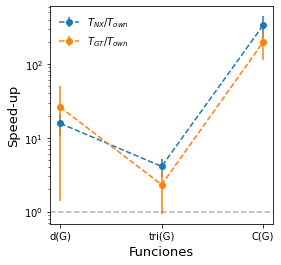

In [54]:
plot_comp_times(summaries=[summary_nx, summary_gt], method_names=['NX', 'GT'], own_summary=summary_own, own_abbr='own')#, measure_name=['d(G)'])

### Analisis de sensibilidad

In [35]:
def generate_random_networks(num_nodes, num_edges):
    num_nodes = int(num_nodes)
    num_edges = int(num_edges)
    A = np.zeros(shape=(num_nodes, num_nodes), dtype=np.bool)
    E = np.random.randint(num_nodes, size=(num_edges, 2))
    for i_e in range(num_edges):
        while (E[i_e, 0] == E[i_e, 1]):
            E[i_e, 0] = np.random.randint(num_nodes)
            E[i_e, 1] = np.random.randint(num_nodes)
        A[E[i_e, 0], E[i_e, 1]] = 1
        A[E[i_e, 1], E[i_e, 0]] = 1
    return A

**Informe:** indicar porque la matriz de adjacencia se usa como boolean.

In [36]:
A_rand_N10   = generate_random_networks(num_nodes=10 , num_edges=1_000)
A_rand_N100  = generate_random_networks(num_nodes=100, num_edges=10_000)
A_rand_N1k   = generate_random_networks(num_nodes=1000, num_edges=100_000)
#A_rand_N10k  = generate_random_networks(num_nodes=10000, num_edges=10_000_000)
#A_rand_N100k = generate_random_networks(num_nodes=100000, num_edges=1_000_000)

/tmp/ipykernel_19988/968793958.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = np.zeros(shape=(num_nodes, num_nodes), dtype=np.bool)


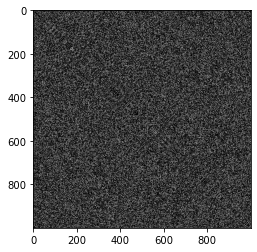

In [37]:
#plt.figure(figsize=(4,4), facecolor='w'); 
f, ax = plt.subplots(figsize=(4,4), facecolor='w')
im = ax.imshow(A_rand_N1k, cmap='Greys_r'); 
#plt.colorbar(im, ax=ax)

In [38]:
get_num_threads()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


6

----

In [137]:

rep=20

In [138]:
%%time 
set_num_threads(1)
var_N10_summary = get_times(
    A=A_rand_N10, 
    f_degree=node_degree_njit, #node_degree_parallel,
    f_tri=get_triangles_per_node,#own_parallel_triangle_comp, 
    f_clust=node_degree_njit,#parallel_global_clustering_coef, 
    rep=rep)

var_N100_summary = get_times(
    A=A_rand_N100, 
    f_degree=node_degree_njit, # node_degree_parallel, 
    f_tri=get_triangles_per_node, # own_parallel_triangle_comp, 
    f_clust=node_degree_njit, # parallel_global_clustering_coef, 
    rep=rep)

var_N1k_summary = get_times(
    A=A_rand_N1k, 
    f_degree=node_degree_njit, #node_degree_parallel, 
    f_tri=get_triangles_per_node, #own_parallel_triangle_comp, 
    f_clust=node_degree_njit, #parallel_global_clustering_coef, 
    rep=rep)

_ = """
    node_degree_parallel
    own_parallel_triangle_comp
    parallel_global_clustering_coef
"""
# var_N10k_summary = get_times(
#    A=A_rand_N10k, 
#    f_degree=node_degree_njit, 
#    f_tri=get_triangles_per_node, 
#    f_clust=node_degree_njit, rep=rep)

CPU times: user 16 s, sys: 20.1 ms, total: 16 s
Wall time: 16 s


In [171]:
%%time
var_N10_summary_nx  = get_times_nx(A=A_rand_N10, rep=rep)
var_N100_summary_nx = get_times_nx(A=A_rand_N100, rep=rep)
var_N1k_summary_nx  = get_times_nx(A=A_rand_N1k, rep=rep)


CPU times: user 1min 57s, sys: 23.8 ms, total: 1min 57s
Wall time: 1min 57s


In [185]:
%%time
var_N10_summary_gt  = get_times_gt(A=A_rand_N10, rep=rep)
var_N100_summary_gt = get_times_gt(A=A_rand_N100, rep=rep)
var_N1k_summary_gt  = get_times_gt(A=A_rand_N1k, rep=rep)


CPU times: user 1min 40s, sys: 24 s, total: 2min 4s
Wall time: 1min 32s


In [141]:
#var_N10_summary

In [142]:
def reshape_summaries(l_summaries, l_N):
    new_summaries = {}
    for i in range(len(l_summaries)):
        new_summaries[l_N[i]] = {
            'd' : l_summaries[i]['times']['d'],
            't' : l_summaries[i]['times']['t'],
            'c' : l_summaries[i]['times']['c'],
        }
    return new_summaries

In [143]:
l_N=[10,100,1_000]

In [172]:
%%time
N_summaries_nx = reshape_summaries(
    l_summaries=[var_N10_summary_nx, var_N100_summary_nx, var_N1k_summary_nx ], 
    l_N=l_N
)

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 16.7 µs


In [186]:
%%time
N_summaries_gt = reshape_summaries(
    l_summaries=[var_N10_summary_gt, var_N100_summary_gt, var_N1k_summary_gt ], #
    l_N=l_N
)

CPU times: user 87 µs, sys: 6 µs, total: 93 µs
Wall time: 17.9 µs


In [146]:
%%time
N_summaries_own = reshape_summaries(
    l_summaries=[var_N10_summary, var_N100_summary, var_N1k_summary ], #
    l_N=l_N
)

CPU times: user 158 µs, sys: 8 µs, total: 166 µs
Wall time: 36.2 µs


In [147]:
np.std(N_summaries_own[1000]['c'])

0.00010723894027429284

In [148]:
tmp = (N_summaries_nx[1000]['c'] / N_summaries_own[1000]['c'])
np.mean(tmp), np.std(tmp)

(25367.973566496068, 11747.096020356536)

In [173]:
N_summaries_nx[1000]['d']

array([0.00055003, 0.00080347, 0.00069809, 0.00068188, 0.00067806,
       0.00091934, 0.00070643, 0.00072408, 0.00069928, 0.0007031 ,
       0.00108528, 0.00073147, 0.00067973, 0.0006988 , 0.00069427,
       0.0006876 , 0.00073695, 0.00072622, 0.00069761, 0.00070548])

In [182]:
N_summaries_gt[1000]['d']

array([1.73807144e-04, 3.09944153e-05, 2.28881836e-05, 4.02927399e-05,
       2.31266022e-05, 3.64780426e-05, 6.38961792e-05, 2.43186951e-05,
       5.43594360e-05, 4.41074371e-05, 3.12328339e-05, 2.38418579e-05,
       3.29017639e-05, 4.05311584e-05, 4.29153442e-05, 2.43186951e-05,
       5.41210175e-05, 3.05175781e-05, 4.38690186e-05, 2.50339508e-05])

array([0.00032735, 0.00028133, 0.00024438, 0.00024176, 0.0002501 ,
       0.00024343, 0.00024652, 0.00050211, 0.00022173, 0.00024319,
       0.0002296 , 0.00023651, 0.00024843, 0.00022483, 0.00034213,
       0.0002315 , 0.00025058, 0.00024533, 0.00023127, 0.00024867])

In [158]:
N_summaries_own[1000]['d']

array([1.63793564e-04, 2.11000443e-04, 2.52008438e-04, 7.41481781e-05,
       7.39097595e-05, 7.15255737e-05, 8.67843628e-05, 7.65323639e-05,
       2.06708908e-04, 7.17639923e-05, 1.09195709e-04, 7.43865967e-05,
       7.41481781e-05, 7.29560852e-05, 2.16007233e-04, 7.48634338e-05,
       1.80721283e-04, 7.60555267e-05, 1.81674957e-04, 7.48634338e-05])

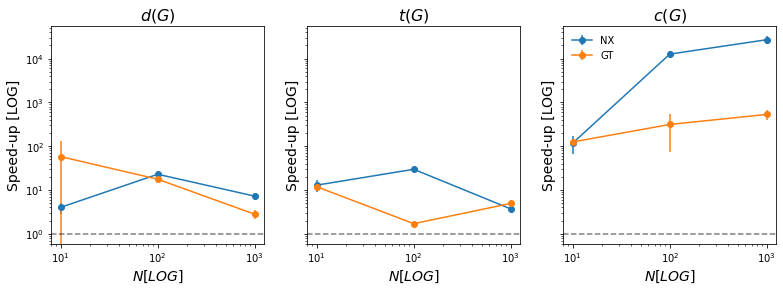

In [164]:
f, ax = plt.subplots(figsize=(13,4), facecolor='w', nrows=1, ncols=3, sharey=True)
l_keys = ['d', 't', 'c']
l_titles = ['$d(G)$', '$t(G)$', '$c(G)$']

ax[0].set_ylabel("Speed-up", fontsize=14)
for i_k in range(len(l_keys)):
    tmp_std  = [(np.std (N_summaries_nx[N][l_keys[i_k]][2:] / N_summaries_own[N][l_keys[i_k]][2:])) for N in l_N]
    tmp_mean = [np.mean(N_summaries_nx[N][l_keys[i_k]][2:] / N_summaries_own[N][l_keys[i_k]][2:]) for N in l_N]
    tmp_std = np.array(tmp_std)
    if i_k ==2 :
        ax[i_k].errorbar(l_N, tmp_mean, yerr=tmp_std, marker='o', label='NX')
    else:
        ax[i_k].errorbar(l_N, tmp_mean, yerr=tmp_std, marker='o')
        
    
    tmp_std  = [(np.std (N_summaries_gt[N][l_keys[i_k]][2:] / N_summaries_own[N][l_keys[i_k]][2:])) for N in l_N]
    tmp_mean = [np.mean(N_summaries_gt[N][l_keys[i_k]][2:] / N_summaries_own[N][l_keys[i_k]][2:]) for N in l_N]
    tmp_std = np.array(tmp_std)
    if i_k ==2 :
        ax[i_k].errorbar(l_N, tmp_mean, yerr=tmp_std, marker='o', label='GT')
    else:
        ax[i_k].errorbar(l_N, tmp_mean, yerr=tmp_std, marker='o')
        
    ax[i_k].set_xlabel("$N[LOG]$", fontsize=14)
    ax[i_k].set_ylabel("Speed-up [LOG]", fontsize=14)
    ax[i_k].loglog()#semilogx()
    ax[i_k].set_title(l_titles[i_k], fontsize=16)
    ax[i_k].axhline(1, ls='--', color='k', alpha=0.5)

plt.legend(frameon=False)
#plt.savefig("figs/speedup_fig2.pdf", bbox_inches='tight')

---

In [ ]:
plot_comp_times(summaries=[var_N100_summary], method_names=['N100'], own_summary=var_N10_summary, own_abbr='N10')#, measure_name=['d(G)'])

In [ ]:
res_avg_node_degree = avg_node_degree(A_rand, rep=10)

In [ ]:
SU_py_para = res_avg_node_degree['comptimes'][0] / res_avg_node_degree['comptimes'][-1]
SU_njit_para = res_avg_node_degree['comptimes'][1] / res_avg_node_degree['comptimes'][-1]

In [ ]:
print (np.mean(SU_py_para), np.std(SU_py_para))
print (np.mean(SU_njit_para), np.std(SU_njit_para))

In [ ]:
l_N = [1e1, 1e2, 1e3, 1e4, 1e5] #[ 10**i for i in range(4,13)] #[1e2, 1e3, 1e4]

In [ ]:
%%time
l_res_avg_node_degree = []
for temp_num_nodes in l_N:#,1e5]:
    print ("generating net")
    A_rand = generate_random_networks(
        num_nodes=temp_num_nodes, 
        num_edges=temp_num_nodes#*50
    )
    
    print ("computing (%i repetitions)" % 10)
    res_avg_node_degree = avg_node_degree(A_rand, rep=10)
    
    l_res_avg_node_degree.append( res_avg_node_degree )

In [ ]:
print (res_avg_node_degree['comptimes'][0] )
print (res_avg_node_degree['comptimes'][-1] )

In [ ]:
l_mean_py_para = []; l_std_py_para = []
l_mean_njit_para = []; l_std_njit_para = []

for i in range(len(l_N)):
    i_N = l_N[i]
    res_avg_node_degree = l_res_avg_node_degree[i]
    
    SU_py_para   = res_avg_node_degree['comptimes'][0] / res_avg_node_degree['comptimes'][-1]
    SU_njit_para = res_avg_node_degree['comptimes'][1] / res_avg_node_degree['comptimes'][-1]
    
    l_mean_py_para.append( np.mean(SU_py_para) )
    l_std_py_para.append( np.std(SU_py_para) )
    l_mean_njit_para.append( np.mean(SU_njit_para) )
    l_std_njit_para.append( np.std(SU_njit_para) )

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), facecolor='w')
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)

ax.errorbar(l_N, l_mean_py_para  , yerr=l_std_py_para  , color='grey', marker='', ls='--', lw=2.5, label='$SU_{(python, p)}$') #uplims=True, label='uplims=True
ax.errorbar(l_N, l_mean_njit_para, yerr=l_std_njit_para, color='k'   , marker='', ls='--', lw=2.5, label='$SU_{(njit, p)}$') 

#plt.semilogy()
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xlabel("$N$ [LOG_2]", fontsize=14)
ax.set_ylabel("Speed-up $(SU)$ [LOG_10]", fontsize=14)
plt.legend(fontsize=11)

In [ ]:
len(edges), np.min(edges)

In [ ]:
#plt.figure(figsize=(4,4), facecolor='w'); plt.imshow(A_karate, cmap='Greys_r');

In [ ]:
get_num_triangles(A=np.array([
    [0,1,0,1],
    [1,0,1,1],
    [0,1,0,1],
    [1,1,1,0]
]))

In [ ]:
A_karate[0,1], A_karate[1,0]

In [ ]:
print(get_num_triangles(A=A_karate))
print(get_num_triangles_parallel(A=A_karate, e_pairs = get_index_pairs(A_karate.shape[0])))

In [ ]:
A_karate.shape[0], get_index_pairs(N=A_karate.shape[0]).shape

In [ ]:
test_complete = np.ones(shape=(10,10), dtype=int)
np.fill_diagonal(test_complete, 0)
print (test_complete)

In [ ]:
global_clustering_coef(A=np.array([
    [0,1,1,1],
    [1,0,1,1],
    [1,1,0,1],
    [1,1,1,0]
]))

In [ ]:
global_clustering_coef(A=test_complete)

In [ ]:
int_A_karate = np.asarray(A_karate, dtype=np.int32)
(int_A_karate@int_A_karate@int_A_karate).diagonal()//2

In [ ]:
global_clustering_coef(A=A_karate)

$c_u = \frac{2}{deg^{tot}(u)(deg^{tot}(u)-1) - 2deg^{\leftrightarrow}(u)}
             T(u),$
             
             
$c_u = \frac{2 T(u)}{deg(u)(deg(u)-1)}$

In [ ]:
0.2556818181818182*2

In [ ]:
0.5706384782076823*3

In [ ]:
own_triangle_comp(A=np.array([
    [0,1,0,1],
    [1,0,1,1],
    [0,1,0,1],
    [1,1,1,0]
]))

In [ ]:
own_triangle_comp(A_karate)

In [ ]:
res_avg_node_degree = avg_node_degree(A_karate, rep=10)

In [ ]:
plot_avg_node_degree()

#### Networkx

```python
import networkx as nx
A = np.matrix([
	[0,1,0,0,0],
	[1,0,1,0,0],
	[0,1,0,1,1],
	[0,0,1,0,1],
	[0,0,1,1,0]
])
MyGraph = nx.from_numpy_matrix(A)
nx.draw(MyGraph)
```


#### Graph-tools

```python
import graph_tool as gt
g = gt.Graph(directed=False)
g.add_edge_list(transpose(transpose(adj).nonzero()))
```

In [ ]:
#--------------------------------------------------------------------------------------------------

In [ ]:
get_num_threads()

In [ ]:
# CAMBIAR
l_threads = [1, 2, 3, 4, 5, 6]
l_threads

In [ ]:
rep = 20

In [ ]:
d_summaries = {}
for i in range(len(l_threads)):
    i_th = l_threads[i]
    print ("%i cores" % get_num_threads())
    set_num_threads(i_th)
    d_summaries[i_th] = get_times(
        A=A_rand_N1k, 
        f_degree=avg_node_degree_parallel, 
        f_tri=own_parallel_triangle_comp, 
        f_clust=parallel_global_clustering_coef, rep=rep
    )

In [ ]:
def last_plot():
    l_mean = []; l_std = [];
    for i_th in l_threads[1:]:
        tmp_times = (d_summaries[1]['times']['d'][2:] / d_summaries[i_th]['times']['d'][2:])
        tmp_mean = np.mean(tmp_times)
        tmp_std  = np.std(tmp_times)
        print (tmp_mean, tmp_std)
        l_mean.append(tmp_mean)
        l_std.append(tmp_std)
    
    f, ax = plt.subplots(figsize=(4,4), facecolor='w')
    ax.errorbar(l_threads[1:], l_mean, yerr=l_std)
    ax.set_xticks(l_threads[1:])
    #ax.set_xscale('log', basex=2)
    ax.set_xlabel("# threads", fontsize=14)
    ax.set_ylabel(r"eficiencia = $\frac{T_{1}}{T_{i}}$", fontsize=14)# , i \in {2,4,8,16}
    plt.savefig("figs/eficiencia_fig3.pdf", bbox_inches='tight')
    
last_plot()